In [18]:
#@title Libraries and Global variables
%%capture
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
!pip install mlxtend --upgrade --no-deps
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth
!pip install scipy==1.9.0
!pip install networkx==3.0
from scipy.spatial import distance
import networkx as nx
import networkx.algorithms.community as nxcom
import warnings
warnings.filterwarnings("ignore")
# Global variables to save the features/graphs of the embeddings
all_KNNs, all_graphs = {}, {}
Use_Cats, Percent_of_neighbors = True, 5

# ***Libraries & Global Variables*** ⬆

---

# ***Methods*** ⬇

In [2]:
#@title Method for removing outliers based on IQR
def remove_outliers(df:pd.DataFrame, col:str)->pd.DataFrame:
  df_no_outlier = df[[col]].copy()
  Q1 = df_no_outlier[col].quantile(0.25)
  Q3 = df_no_outlier[col].quantile(0.75)
  IQR = Q3 - Q1
  indx = df_no_outlier.loc[(df_no_outlier[col]<(Q1-1.5*IQR))|(df_no_outlier[col]>(Q3+1.5*IQR))].index.tolist()
  df_no_outlier = df_no_outlier.loc[~df_no_outlier.index.isin(indx)]
  print(f'quartile 1: {Q1}')
  print(f'quartile 3: {Q3}')
  print(f'Interquartile range: {IQR}')
  print(f'Number of documents before removing the outliers based on the lenght of document: {len(df)}')
  print(f'Number of documents after removing the outliers based on the lenght of document: {len(df_no_outlier)}')
  print(f'New Mean: {df_no_outlier.mean().values[0]}')
  print(f'New Max: {df_no_outlier.max().values[0]}')
  print(f'New Min: {df_no_outlier.min().values[0]}')
  print()
  f, axes= plt.subplots(figsize=(12, 7))
  sns.histplot(data=df_no_outlier, x=col, kde=True, color='g', ax=axes, log_scale=[True, False])
  plt.show()
  return df_no_outlier

In [3]:
#@title Find Docs having frequent or high TF_IDF value categories
def Docs_top_cats(frequent_cats:pd.DataFrame, df_single_tfidf_cats:pd.DataFrame, N:int, threshold:float, min_docs:int)->[list, list]:
  N_Docs, freq_and_high, Docs_with_top_cats  = 0, [], None
  # Try different values for the number freq docs and the threshold for TF-IDF to have the minimum number of docs
  while N_Docs < min_docs:
    N_Docs, Docs_with_top_cats, high_frequent = 0, [], []
    for i in frequent_cats.iloc[:N]['itemsets']:
      high_frequent = high_frequent + list(i)
    high_tf_idf = df_single_tfidf_cats.loc[df_single_tfidf_cats['tf_idf'] >= threshold].index.tolist()
    freq_and_high = list(set(high_tf_idf).union(set(high_frequent)))
    for i in range(len(df_labels)):
      if df_labels.loc[i][freq_and_high].sum() != 0:
        Docs_with_top_cats.append(i)
    N_Docs = len(Docs_with_top_cats)
    # Change N and threshold
    if N <= len(frequent_cats)-1: N += 1
    if (threshold-10**(-3))>=0: threshold -= 10**(-3)
  return Docs_with_top_cats, freq_and_high

In [4]:
#@title Calculate Hamming Distance of the rows of df
def Hamming_Distance(df:pd.DataFrame)->pd.DataFrame:
  Hamming_dis = pd.DataFrame(columns=df.index, index=df.index)
  for i in range(len(df)):
    for j in range(i, len(df), 1):
      a = df.astype(int).loc[df.index[i], :].values.tolist()
      b = df.astype(int).loc[df.index[j], :].values.tolist()
      Hamming_dis.loc[df.index[i], df.index[j]] = distance.hamming(a, b)
      Hamming_dis.loc[df.index[j], df.index[i]] = Hamming_dis.loc[df.index[i]][df.index[j]]
  return Hamming_dis

In [19]:
from pandas.core.arrays import boolean
#@title Class for creating (Recursive) KNNs and derive features to compare them
class KNN:

  def __init__(self):
    pass


  def L2_Norm(Vecs:list, Docs_with_top_cats:list)->pd.DataFrame:
    # ----------------------------
    # Calculate L2 Norm between docs
    # ----------------------------
    df = pd.DataFrame(columns=Docs_with_top_cats, index=Docs_with_top_cats)
    for i in range(len(Docs_with_top_cats)):
      if i%100 == 0:
        print(i)
      for j in range(i, len(Docs_with_top_cats), 1):
        a = Vecs[Docs_with_top_cats[i]]
        b = Vecs[Docs_with_top_cats[j]]
        x = np.linalg.norm(a-b)
        df.loc[Docs_with_top_cats[i]][Docs_with_top_cats[j]] = x
        df.loc[Docs_with_top_cats[j]][Docs_with_top_cats[i]] = x
    return df



  def bin_vec_add(self, df_labels:pd.DataFrame, ind_doc:list)->int:
    # ----------------------------
    # Count the occurences of 2 when adding binary vectors
    # ----------------------------
    occ_2 = 0
    for i in range(len(ind_doc)):
      for j in range(i+1, len(ind_doc), 1):
        a = df_labels.astype(int).loc[df_labels.index[ind_doc[i]], :].values
        b = df_labels.astype(int).loc[df_labels.index[ind_doc[j]], :].values
        occ_2 += np.count_nonzero((a+b) == 2)
    return occ_2



  def recursive_knn(self, sim:np.array, Docs_Cats:dict, Docs_with_top_cats:list, Dict:dict, Properties:dict, node:int, current:int, neighbors:list, k:int, nHops:int, counter:int)->[dict, dict]:
    # ----------------------------
    # Create Recursive KNN based on k and nHops
    # Repeat the same approach as knn, but for the neighbors
    # Dict: store RKKN | Properties: store the properties (# Neighbors, Mean Cos-Sim, # Cats) of RKNN | node: the main node of KNN |
    # current: current node of RKNN we are checking | counter: which nHops (layer) we are at
    # ----------------------------
    if counter <= nHops:
      # Update the whole neighbors of the node
      Properties[node][1] = list(set(Properties[node][1]).union(set(neighbors)))
      # Find closest neighbors
      for i in neighbors:
        if i != current:
          ind = sim[i].argsort()[-k-1:]
          li = []
          try:
            # Save the categories
            for j in ind:
              li = li + Docs_Cats[Docs_with_top_cats[j]]
          except:
            pass
          ind_doc = [Docs_with_top_cats[j] for j in ind]
          # Create Recursive KNN (next layer)
          try:
            Dict[node][str(counter)].append({str(Docs_with_top_cats[i]): [np.array(ind_doc), sim[i][ind], np.array(li)]})
          except:
            Dict[node][str(counter)] = [{str(Docs_with_top_cats[i]): [np.array(ind_doc), sim[i][ind], np.array(li)]}]
          # Update the properties of the node
          Properties[node][2].append(sim[i][ind])
          Properties[node][3] = list(set(Properties[node][3]).union(set(li)))
          # KNN for neighbor i
          Dict, Properties = self.recursive_knn(sim, Docs_Cats, Docs_with_top_cats, Dict, Properties, node, current=i, neighbors=ind, k=k, nHops=nHops, counter=counter+1)
    return Dict, Properties



  def knn(self, sim:np.array, Docs_Cats:dict, df_labels:pd.DataFrame, Docs_with_top_cats:list, k:int, nHops:int)->[dict, dict, dict, pd.DataFrame]:
    # ----------------------------
    # KNN and Recursive KNN
    # Create the first nHops layer (KNN) with finding the closest neighbors using the similarity matrix
    # sim: Similarty Matrix | Docs_Cats: documents as the keys and their categories as the values | df_labels: document-category matrix |
    # Docs_with_top_cats: list of selected documentes | k: number of neighbors (KNN) | nHops: how many layers does RKNN have
    # ----------------------------
    Dict, Properties, Scores = {}, {}, {}
    df_graph = pd.DataFrame(sim.copy(), columns=Docs_with_top_cats, index=Docs_with_top_cats)
    # Create KNN
    # Find closest neighbors
    for i in range(len(sim)):
      ind = sim[i].argsort()[-k-1:]
      li = []
      try:
        # Save the categories
        for j in ind:
          li = li + Docs_Cats[Docs_with_top_cats[j]]
      except:
        pass
      node = Docs_with_top_cats[i]
      ind_doc = [Docs_with_top_cats[j] for j in ind]
      # Update adjacency matrix
      df_graph.loc[node, :] = 0
      df_graph.loc[node, ind_doc] = 1
      df_graph.loc[node, node] = 0
      # Scoring method for each node
      # 1. Hamming Distance
      # ...
      # 2. Union of Cats
      # Scores[node] = len(set(li))
      # 3. Adding charactristic vectors
      Scores[node] = self.bin_vec_add(df_labels, ind_doc)

      # KNN (First layer)
      Dict[node] = {'1': {str(node): [np.array(ind_doc), sim[i][ind], np.array(li)]}}
      Properties[node] = [0, [], [sim[i][ind]], []]
      # Create Recursive KNN
      Dict, Properties = self.recursive_knn(sim, Docs_Cats, Docs_with_top_cats, Dict, Properties, node=node, current=i, neighbors=ind, k=k, nHops=nHops, counter=2)
      # Update the properties of the node
      Properties[node][0] = len(Properties[node][1])
      Properties[node][1] = np.array([Docs_with_top_cats[j] for j in Properties[node][1]])
      Properties[node][2] = np.array(Properties[node][2])

    return Dict, Properties, Scores, df_graph



  def Extract_Features(self, R_KNN_Properties:dict, cos_or_L2:str, name:str, community_level:bool):
    # ----------------------------
    # Extract features and plot the distribution of the extracted features
    # ----------------------------
    global all_KNNs
    # finding 5% of the docs with most and least neighbors in their recursive knn
    keys = np.array(list(dict(sorted(R_KNN_Properties.items(), key=lambda item: item[1][0])).keys()))
    # Extracted Properties from R_KNN_Properties: [# neighbors, mean cos-sim or L2, # cats]
    Extracted_Properties = []
    for i in keys:
      Extracted_Properties.append([R_KNN_Properties[i][0], R_KNN_Properties[i][2].mean(), len(R_KNN_Properties[i][3])])
    Extracted_Properties = np.array(Extracted_Properties)
    if community_level == True:
      return Extracted_Properties, keys
    else:
      all_KNNs[name]['all'] = []
      all_KNNs[name]['all'].append(Extracted_Properties)
      return keys



  def Plot(self, axes, i, k, arr, counter, colors, label, Log_scale):
    # ----------------------------
    # Plot the histogrms
    # ----------------------------
    global Percent_of_neighbors
    df_temp = pd.DataFrame({i: arr})
    sns.histplot(data=df_temp, x=i, ax=axes[counter][0], log_scale=Log_scale, color=colors[k], element='step', label=list(all_KNNs.keys())[k], kde=True)
    df_temp = pd.DataFrame({i: arr[:(len(keys)*5//100)]})
    sns.histplot(data=df_temp, x=i, ax=axes[counter+1][0], log_scale=Log_scale, color=colors[k],  element='step', label=list(all_KNNs.keys())[k], kde=True)
    df_temp = pd.DataFrame({i: arr[-(len(keys)*5//100):]})
    sns.histplot(data=df_temp, x=i, ax=axes[counter+2][0], log_scale=Log_scale, color=colors[k], element='step', label=list(all_KNNs.keys())[k], kde=True)
    if list(all_KNNs.keys())[k] != 'random':
      # Excluding random
      df_temp = pd.DataFrame({i: arr})
      sns.histplot(data=df_temp, x=i, ax=axes[counter][1], log_scale=Log_scale, label=list(all_KNNs.keys())[k], color=colors[k], element='step')
      df_temp = pd.DataFrame({i: arr[:(len(keys)*5//100)]})
      sns.histplot(data=df_temp, x=i, ax=axes[counter+1][1], log_scale=Log_scale, label=list(all_KNNs.keys())[k], color=colors[k], element='step')
      df_temp = pd.DataFrame({i: arr[-(len(keys)*5//100):]})
      sns.histplot(data=df_temp, x=i, ax=axes[counter+2][1], log_scale=Log_scale, label=list(all_KNNs.keys())[k], color=colors[k], element='step')
    for k, kk in enumerate(['all docs', f'{Percent_of_neighbors}% docs with least neighbors', f'{Percent_of_neighbors}% docs with most neighbors']):
      # Add title and labels
      axes[counter+k][0].legend()
      axes[counter+k][0].set_title(kk)
      axes[counter+k][1].legend()
      axes[counter+k][1].set_title(kk)
    return axes



  def Plot_Features(self):
    # ----------------------------
    # Plot features
    # ----------------------------
    global all_KNNs
    f, axes= plt.subplots(9, 2, figsize=(23, 50))
    counter = 0
    colors = ['red', 'blue', 'green', 'grey']
    sim = 'mean L2-norm'
    if 'cos' in cos_or_L2:
      sim = 'mean cos-sim'
    for count, i in enumerate(['# neighbors', sim, '# cats']):
      for k in range(len(all_KNNs.keys())):
        try:
          # Including random Matrix if available
          arr = all_KNNs[list(all_KNNs.keys())[k]]['all'][0]
          label = list(all_KNNs.keys())[k]
          axes = self.Plot(axes, i, k, arr[:, count], counter, colors, label, Log_scale=[True, False])
        except:
          pass
      counter += 3
    plt.show()



  def Plot_Scores(self, keys, KNN_scores):
    # ----------------------------
    # Calculate and plot the scores
    # ----------------------------
    global all_KNNs
    f, axes= plt.subplots(3, 2, figsize=(23, 17))
    counter = 0
    cl = '# 2s in binary vector addition for each node in RKNNs'
    colors = ['red', 'blue', 'green', 'grey']
    for k in range(len(all_KNNs.keys())):
      arr = all_KNNs[list(all_KNNs.keys())[k]]['scores']
      label=list(all_KNNs.keys())[k]
      axes = self.Plot(axes, cl, k, arr, counter, colors, label, Log_scale=[False, False])
    plt.show()

In [6]:
#@title Class for calling KNN and Recursive KNN with parameters{form-width: "400px"}
def Create_RKNN(KNN_object:object, Docs_with_top_cats:list, embedding_name:list,
                embedding_file:list, cos_or_L2:str, nHops:int, K: int,
                Docs_Cats: dict = None, df_labels: pd.DataFrame = None):
  # Global variables to save the features/graphs of the embeddings
  global all_KNNs, all_graphs, Use_Cats
  for vec_embedding in embedding_file:
    for name in embedding_name:
      if name in vec_embedding:
        all_KNNs[name] = {}
        Vecs = []
        # Read vector embeddings
        if vec_embedding != 'random':
          try:
            Vectors = open(f'/content/{vec_embedding}', 'r')
            Lines = Vectors.readlines()
            for i, line in enumerate(Lines):
              if i > 0:
                arr = line.split()[1:]
                Vecs.append([float(j) for j in arr])
            Vecs = np.array(Vecs)
          except:
            Vecs = pickle.load(open(f"/content/{vec_embedding}", "rb"))
          # Calculate similarity Matrix
          similarity = pd.DataFrame()
          if cos_or_L2 == 'cos': # Cos-Sim
            cos_sim = cosine_similarity(Vecs[Docs_with_top_cats])
            similarity = cos_sim.copy()
          else: # L2 Norm
            L2 = Object.L2_Norm(Vecs, Docs_with_top_cats)
            similarity = L2.values
        else: # Create a Random matrix as similarity
          if cos_or_L2 == 'cos':
            similarity = np.random.rand(len(Docs_with_top_cats), len(Docs_with_top_cats))
          else:
            # Random Matrix using L2 norm
            similarity = np.random.normal(loc=1.8829, scale=0.4632, size=(len(Docs_with_top_cats), len(Docs_with_top_cats)))
        # Create Recursive KNN
        if Use_Cats:
          Dict_top_k, R_KNN_Properties, KNN_scores, df_knn_graph = Object.knn(similarity, Docs_Cats, df_labels, Docs_with_top_cats, int(K), int(nHops))
        else:
          Dict_top_k, R_KNN_Properties, KNN_scores, df_knn_graph = Object.knn(similarity, [], [], Docs_with_top_cats, int(K), int(nHops))
        # Create and save data needed for creating Networkx graph and detect communities to all_graphs
        df_similarty = pd.DataFrame(similarity, index=df_knn_graph.index, columns=df_knn_graph.columns)
        all_graphs[name] = {'df_graph': df_knn_graph, 'df_similarty': df_similarty, 'Graph': None, 'Communities': []}
        # Extract features of the Recursive KNNs and save it to all_KNNs
        keys = Object.Extract_Features(R_KNN_Properties, cos_or_L2, name,community_level=False)
        all_KNNs[name]['scores'] = []
        for i in keys:
          all_KNNs[name]['scores'].append(KNN_scores[i])
  return Dict_top_k, R_KNN_Properties, KNN_scores, keys

***Community Detection Algorithm*** 👇
```python
networkx.greedy_modularity_communities(G, weight=similarity, resolution=1, cutoff=1, best_n=None)
```
**[*Source*](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.modularity_max.greedy_modularity_communities.html#rce363827c0a4-2)**

This function uses Clauset-Newman-Moore greedy modularity maximization to find the community partition with the largest modularity. Greedy modularity maximization begins with each node in its own community and repeatedly joins the pair of communities that lead to the largest modularity until no further increase in modularity is possible (a maximum).

* **G: NetworkX graph**
* **weight: string or None, optional (default=None)**. ✅
The name of an edge attribute that holds the numerical value used as a weight. If None, then each edge has weight 1. The degree is the sum of the edge weights adjacent to the node.
* **resolution: float, optional (default=1)**. The resolution parameter sets an arbitrary tradeoff between intra-group edges and inter-group edges. If resolution is less than 1, modularity favors larger communities. Greater than 1 favors smaller communities.
* **cutoff: int, optional (default=1)**.
A minimum number of communities below which the merging process stops. The process stops at this number of communities even if modularity is not maximized. The goal is to let the user stop the process early.
* **best_n: int or None, optional (default=None)**
A maximum number of communities above which the merging process will not stop. This forces community merging to continue after modularity starts to decrease until best_n communities remain. If None, don’t force it to continue beyond a maximum.

In [7]:
#@title Class for creating a networkx graph and detect the communities
class Community:

  def __init__(self):
    pass


  def set_node_community(self, G:nx.Graph, communities:list)->nx.Graph:
    # ----------------------------
    # Define community nodes
    # ----------------------------
    '''Add community to node attributes'''
    for c, v_c in enumerate(communities):
        for v in v_c:
            # Add 1 to save 0 for external edges
            G.nodes[v]['community'] = c + 1
    return G


  def set_edge_community(self, G:nx.Graph)->nx.Graph:
    # ----------------------------
    # Define community edges
    # ----------------------------
    '''Find internal edges and add their community to their attributes'''
    for v, w, in G.edges:
        if G.nodes[v]['community'] == G.nodes[w]['community']:
            # Internal edge, mark with community
            G.edges[v, w]['community'] = G.nodes[v]['community']
        else:
            # External edge, mark as 0
            G.edges[v, w]['community'] = 0
    return G


  def get_color(self, i, r_off=1, g_off=1, b_off=1):
    # ----------------------------
    # Define colors for nodes
    # ----------------------------
    '''Assign a color to a vertex.'''
    n = 20
    low, high = 0.1, 0.9
    span = high - low
    r = low + span * (((i + r_off) * 3) % n) / (n - 1)
    g = low + span * (((i + g_off) * 5) % n) / (n - 1)
    b = low + span * (((i + b_off) * 7) % n) / (n - 1)
    return (r, g, b)


  def Community_Detection(self, df_graph:pd.DataFrame, df_similarty:pd.DataFrame, name:str, Resolution:float)->[nx.Graph, list]:
    # ----------------------------
    # Create a networkx graph from the adjacency matrix and find the communities
    # ----------------------------
    graph = nx.from_numpy_array(df_graph.values)
    graph = nx.relabel_nodes(graph, dict(enumerate(df_graph.columns)))
    # Give similarities as weights to edges
    for v, w, in graph.edges:
      graph.edges[v, w]['similarity'] = df_similarty.loc[v][w]
    # Detect Communities
    communities = sorted(nxcom.greedy_modularity_communities(graph, weight='similarity', resolution=Resolution), key=len, reverse=True)
    print(f"The KNN graph has \033[3;32m{len(communities)}\033[0;30m communities.")
    # Set node and edge communities
    graph = self.set_node_community(graph, communities)
    graph = self.set_edge_community(graph)
    try:
      # plot
      node_color = [self.get_color(graph.nodes[v]['community']) for v in graph.nodes]
      # Set community color for edges between members of the same community (internal) and intra-community edges (external)
      external = [(v, w) for v, w in graph.edges if graph.edges[v, w]['community'] == 0]
      internal = [(v, w) for v, w in graph.edges if graph.edges[v, w]['community'] > 0]
      internal_color = ['black' for e in internal]
      pos = nx.spring_layout(graph)
      fig = plt.figure(figsize=(10, 10))
      # Draw external edges
      nx.draw_networkx(graph, pos=pos, node_size=10, edgelist=external, edge_color="silver", with_labels=False, )
      # Draw nodes and internal edges
      nx.draw_networkx(graph, pos=pos, node_size=50, node_color=node_color, edgelist=internal, edge_color=internal_color, with_labels=False)
      plt.title(name)
      plt.show()
    except Exception as e:
      print(e)

    return graph, communities

# ***Methods*** ⬆

---

# ***Main*** ⬇

In [8]:
#@title Reading data AmazonCats_5k.txt
# df_train = pd.read_table('Train.csv', sep=',')
# Lines = df_train['claim'].values.tolist()
AmazonCatsText = open('/content/AmazonCats_5k.txt', 'r')
Lines = AmazonCatsText.readlines()
Docs, Lenght_Docs, Lenght_Uniques_Docs, special_char = {}, [], [], []
for i, line in enumerate(Lines):
  Line = "".join(c for c in line if c.isalnum() or c.isspace())
  special_char = special_char + "".join(c for c in line if not c.isalnum() and not c.isspace()).split()
  # String to array by removing whitespaces and saving the string in Docs dictionary
  arr = Line.split()
  Docs[f'Doc_{i+1}'] = arr
  Lenght_Docs.append(len(arr))
  Lenght_Uniques_Docs.append(len(list(dict.fromkeys(arr))))

AmazonCatsText.close()

# ***Lenght of the Documents:***

-> Lenghts of Documents (number of words and numbers)
Mean: 207.1078
Max: 8611
Min: 2



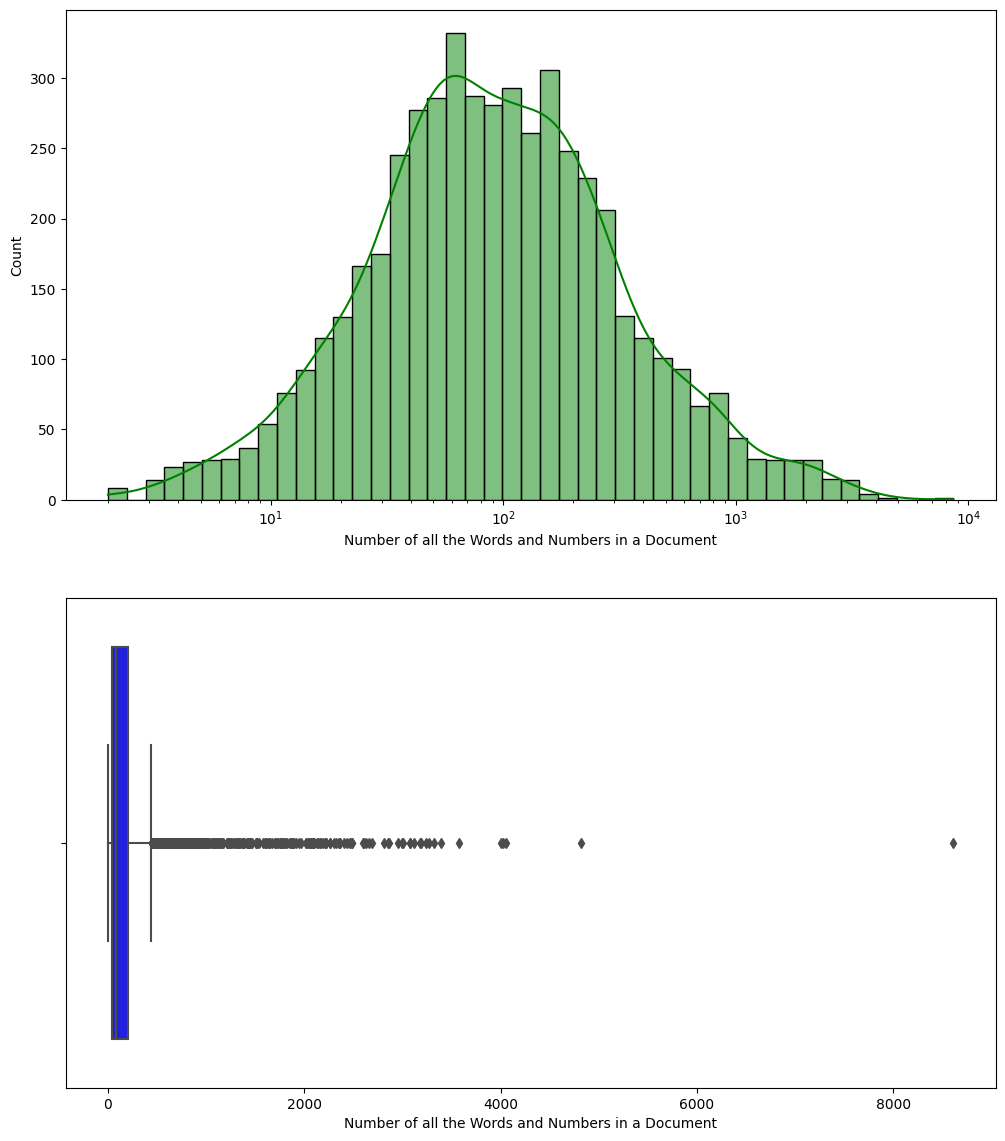

In [9]:
#@title Histogram of the lenghts of the documents
Lenght_Docs = np.array(Lenght_Docs)
print('-> Lenghts of Documents (number of words and numbers)')
print(f'Mean: {np.mean(Lenght_Docs)}')
print(f'Max: {np.max(Lenght_Docs)}')
print(f'Min: {np.min(Lenght_Docs)}')
print()
col = 'Number of all the Words and Numbers in a Document'
df = pd.DataFrame({col: Lenght_Docs})
f, axes= plt.subplots(2, 1, figsize=(12, 14))
sns.histplot(data=df, x=col, kde=True, color='green', ax=axes[0], log_scale=[True, False])
sns.boxplot(data=df, x=col, color='blue', ax=axes[1])

plt.show()

quartile 1: 40.0
quartile 3: 202.0
Interquartile range: 162.0
Number of documents before removing the outliers based on the lenght of document: 5000
Number of documents after removing the outliers based on the lenght of document: 4478
New Mean: 108.1835640911121
New Max: 445
New Min: 2



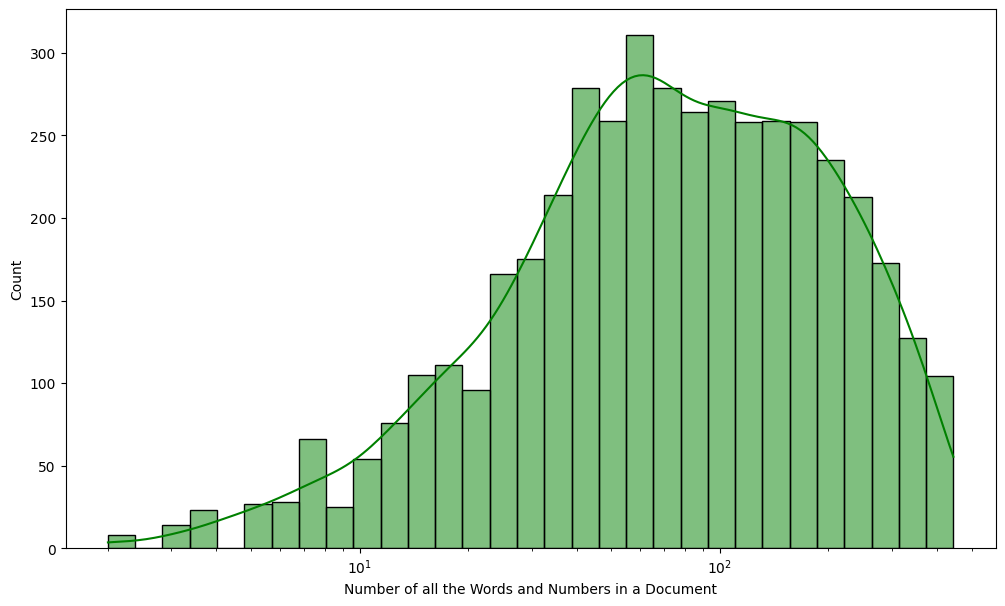

In [10]:
#@title Detect and remove outliers
df_no_outlier = remove_outliers(df, col)

-> Lenghts of Documents (number of words and numbers)
Mean: 118.4644
Max: 1932
Min: 1



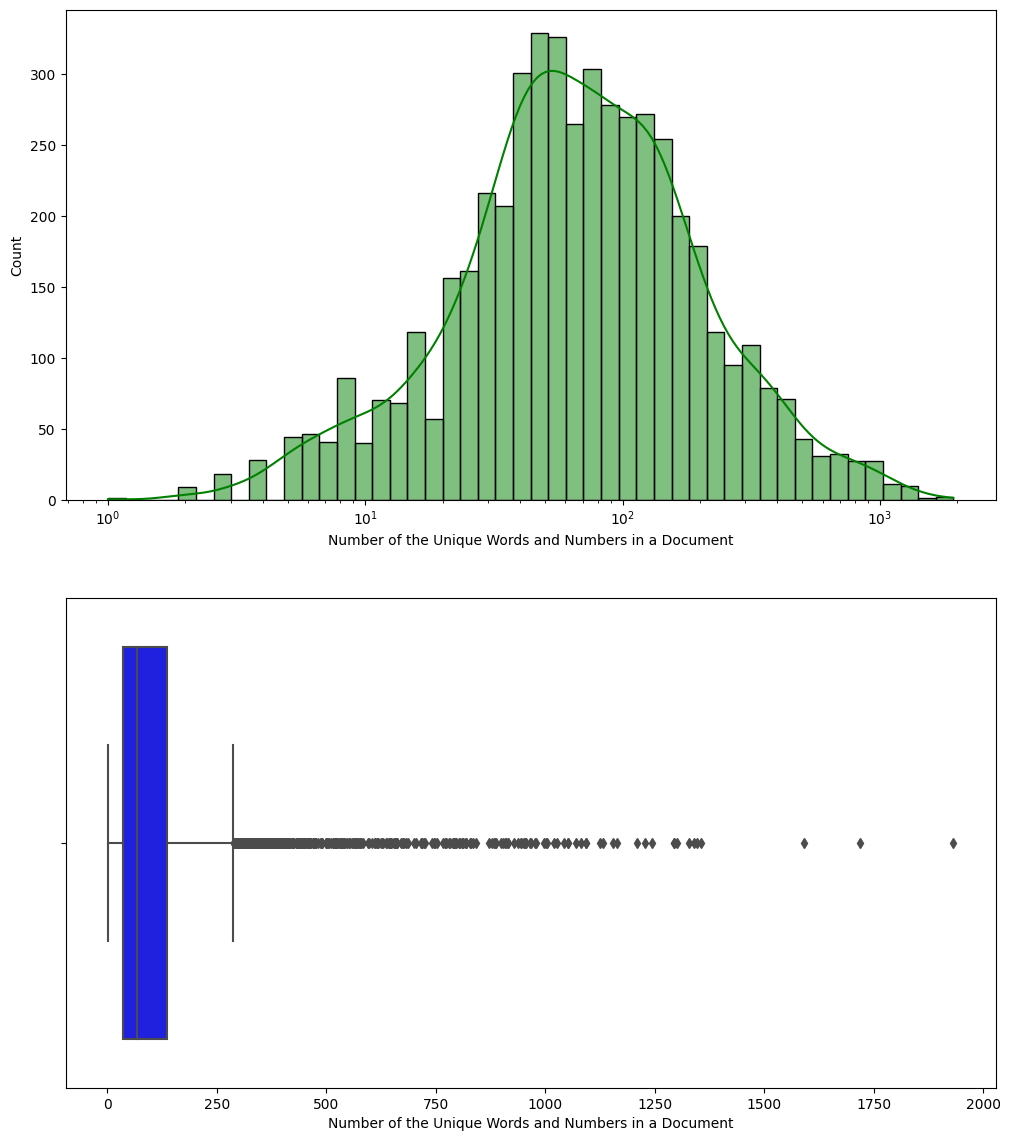

In [11]:
#@title Histogram of the lenghts of the documents (Uniques)
Lenght_Uniques_Docs = np.array(Lenght_Uniques_Docs)
print('-> Lenghts of Documents (number of words and numbers)')
print(f'Mean: {np.mean(Lenght_Uniques_Docs)}')
print(f'Max: {np.max(Lenght_Uniques_Docs)}')
print(f'Min: {np.min(Lenght_Uniques_Docs)}')
print()
col1 = 'Number of the Unique Words and Numbers in a Document'
df1 = pd.DataFrame({col1: Lenght_Uniques_Docs})
f, axes= plt.subplots(2, 1, figsize=(12, 14))
sns.histplot(data=df1, x=col1, kde=True, color='green', ax=axes[0],  log_scale=[True, False])
sns.boxplot(data=df1, x=col1, color='blue', ax=axes[1])
plt.show()

quartile 1: 35.0
quartile 3: 136.0
Interquartile range: 101.0
Number of documents before removing the outliers based on the lenght of document: 5000
Number of documents after removing the outliers based on the lenght of document: 4548
New Mean: 78.30101143359718
New Max: 287
New Min: 1



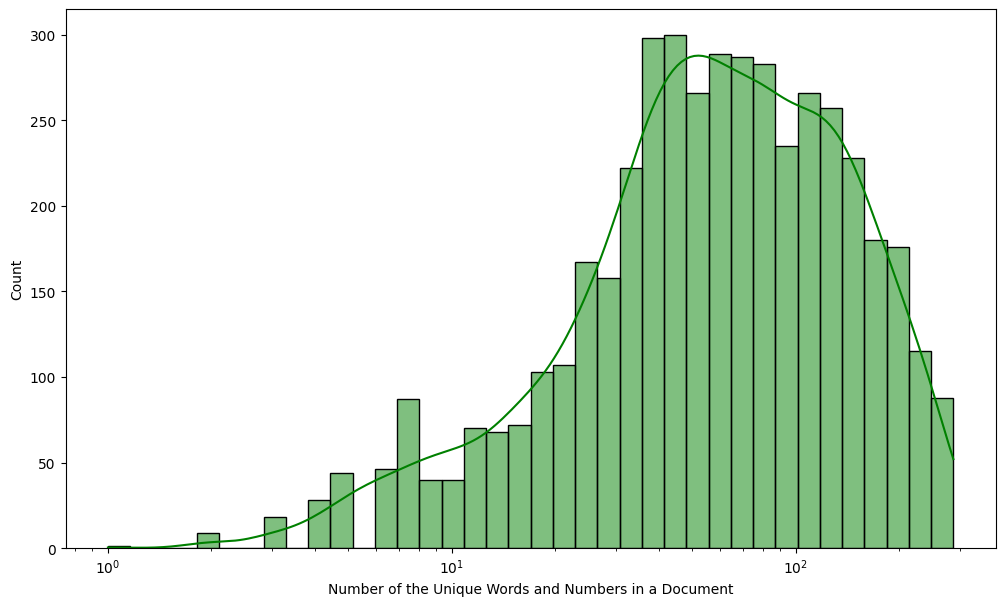

In [12]:
#@title Detect and remove outliers (Unique)
df1_no_outlier = remove_outliers(df1, col1)

# ***Words:***

In [13]:
#@title Words Frequencies
# Words frequency in each document
li, count_all_words = [], {}
for i, j in enumerate(Docs.keys()):
  values, counts = np.unique(Docs[j], return_counts=True)
  li.append(values)
  for k, key in enumerate(values):
    try:
      count_all_words[key] += counts[k]
    except:
      count_all_words[key] = counts[k]

df_count_all_words = pd.DataFrame({'word': count_all_words.keys(), 'count': count_all_words.values()})
print('-> Words Frequencies')
display(df_count_all_words)
print(f'Mean: {np.mean(df_count_all_words["count"])}')
print(f'Max: {np.max(df_count_all_words["count"])}')
print(f'Min: {np.min(df_count_all_words["count"])}')
Q1 = df_count_all_words['count'].quantile(0.25)
Q3 = df_count_all_words['count'].quantile(0.75)
print(f'quartile 1: {Q1}')
print(f'quartile 3: {Q3}')
print(f'Interquartile range: {Q3-Q1}')


# Word frequncy among all documents
te = TransactionEncoder()
te_ary = te.fit(li).transform(li)
df_words = pd.DataFrame(te_ary, columns=te.columns_)
display(df_words)
Words = {}
for i, j in enumerate(df_words.columns):
  Words[j] = df_words[j].sum()

-> Words Frequencies


,word,count
0,1970s,34
1,1980s,29
2,1982,32
3,1984,29
4,1985,43
...,...,...
85282,SoupThis,1
85283,insanely,1
85284,internetclip,1
85285,techinternet,1


Mean: 12.14181528251668
Max: 45786
Min: 1
quartile 1: 1.0
quartile 3: 4.0
Interquartile range: 3.0


,0,00,000,0000,0000000005,0000000007,0000000010,0000000012,0000000015,0000000020,...,zoologist,zoologists,zoology,zoom,zoomed,zooms,zydeco,Árbol,Ö,à
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4996,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4997,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4998,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# ***Categories***

In [14]:
#@title Save categories, create a Doc-Cat marix, frequent categories and combinations
AmazonCatsLabel = open('/content/AmazonCats_5k.labels.txt', 'r')
Lines = AmazonCatsLabel.readlines()
Docs_Cats, all_Cats = [], {}
for i, line in enumerate(Lines):
  a = line.split()
  Docs_Cats.append(a)
  for cat in a:
    try:
      all_Cats[cat] += 1
    except:
      all_Cats[cat] = 1
df_cats = pd.DataFrame({'Cats': all_Cats.keys(), 'count': all_Cats.values()})
print('-> Categories Frequencies')
display(df_cats)
print(f'Mean: {np.mean(df_cats["count"])}')
print(f'Max: {np.max(df_cats["count"])}')
print(f'Min: {np.min(df_cats["count"])}')
te = TransactionEncoder()
te_ary = te.fit(Docs_Cats).transform(Docs_Cats)
df_labels = pd.DataFrame(te_ary, columns=te.columns_)
display(df_labels)

-> Categories Frequencies


,Cats,count
0,afghanistan,1
1,asia,12
2,books,1484
3,history,198
4,classicrock,76
...,...,...
3562,death,1
3563,thinking&problemsolving,1
3564,usbnetworkadapters,1
3565,grills&grillaccessories,1


Mean: 7.1662461452200725
Max: 1484
Min: 1


,&style,&telecommunications,(e),(f),(g),(h),(n),(p),(r),(s),...,xml,yardsigns,yeats,yo-yos,yoga,yogurt,yosemite,youthministry,zesters&reamers,zoology
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4996,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4997,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4998,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# ***TF_IDF***
$tf\_idf(t, d) = tf(t, d) * idf(t)$ which $idf(t) = log [ n/df(t) ]$ and $tf(t ,d) = \text{number of t in d}/\text{total number of terms in d}$

In [15]:
#@title TF_IDF Cats
df_single_tfidf_cats = pd.DataFrame()

def return_doc(doc):
    return doc
# Calculate TF-IDF for all labels
vectorizer = TfidfVectorizer(analyzer='word', tokenizer=return_doc, preprocessor=return_doc, token_pattern=None)
X = vectorizer.fit_transform(Docs_Cats)
get_feature_names_out = vectorizer.get_feature_names_out()
# Mean of TF-IDF values for doc-label pairs
single_tfidf = {}
for i in range(len(get_feature_names_out)):
  single_tfidf[get_feature_names_out[i]] = np.mean(X[:, i].toarray())
df_single_tfidf_cats = pd.DataFrame({'tf_idf': single_tfidf.values()}, index=single_tfidf.keys())
df_single_tfidf_cats.sort_values(by=['tf_idf'], ascending=False, inplace=True)
display(df_single_tfidf_cats.head(10))

,tf_idf
books,0.065052
movies&tv,0.064402
music,0.061101
movies,0.051342
pop,0.039792
rock,0.028509
tv,0.025157
literature&fiction,0.023185
home&kitchen,0.016371
worldmusic,0.016097


In [16]:
#@title Frequent categories and combinations using min_support
Min_support = 0.05 #@param {type:"number"}
frequent_cats = fpgrowth(df_labels, min_support=Min_support, use_colnames=True)
frequent_cats = frequent_cats.sort_values(by=['support'], ascending=False).reset_index(drop=True)
display(frequent_cats)

,support,itemsets
0,0.2968,(books)
1,0.1560,(music)
2,0.1026,(movies&tv)
3,0.0972,(pop)
4,0.0972,"(music, pop)"
5,0.0790,"(literature&fiction, books)"
6,0.0790,(literature&fiction)
7,0.0718,(movies)
8,0.0692,"(movies, movies&tv)"
9,0.0652,(education&reference)


In [17]:
#@title Select (at least Min_docs) documents based on categories frequencies and TF_IDF values
Min_docs = 4000 #@param {type:"integer"}
Docs_with_top_cats , used_cats = Docs_top_cats(frequent_cats, df_single_tfidf_cats, N=5, threshold=0.02, min_docs=4000)
print(f'Number of documents with high TF_IDF value and frequent cats: {len(Docs_with_top_cats)}')

Number of documents with high TF_IDF value and frequent cats: 4061


In [ ]:
#@title Hamming distance between selected docs using their top cats characteristic vectors
Which = 'None' #@param ["Calculate", "Upload", "None"]
if Which == 'Calculate':
  Hamming_dis = Hamming_Distance(df_labels.loc[Docs_with_top_cats][used_cats])
  display(Hamming_dis)
elif Which == 'Upload':
  Hamming_dis = pd.read_csv('/content/Hamming_dis.csv', index_col=0)
  display(Hamming_dis)

# ***Vector Embeddings and KNN & RKNN:***

In [23]:
# Creating KNN and RKNN from the remaining documents
# Prepare variable for create_rknn
#---------------------
# Docs_Cats = Document wise labels (cats)
# df_labels = document x labels (cats) Matrix
# Docs_with_top_cats = Document index number
# The embedding_name should be part of the embedding_file, e.g. 'pretrained' in '../embeddings_pretrained.txt'
# The embedding_name is used as the keys for all_KNNs and all_graphs as they save the features of all given embeddings
#---------------------
all_KNNs, all_graphs = {}, {}
Percent_of_neighbors = 5
cos_or_L2 = 'cos' # ['cos', 'L2']
nHops = 3
K = 4
Use_Cats = True
embedding_name = ['random', 'new.vec', 'orig.vec', 'refined.vec']
embedding_file = ["random", "AmazonCats_5k_new.vec.txt", "AmazonCats_5k_orig.vec.txt", "AmazonCats_5k_refined.vec.txt"]
Object = KNN()
# RKNN, RKNN properties, KNN Scores, sorted documents w.r.t # neighbors
Dict_top_k, R_KNN_Properties, KNN_scores, keys = Create_RKNN(Object, Docs_with_top_cats, embedding_name,
                                                             embedding_file, cos_or_L2, nHops, K, Docs_Cats, df_labels[used_cats])
least_neighbors = keys[:(len(keys)*Percent_of_neighbors//100)]
most_neighbors = keys[-(len(keys)*Percent_of_neighbors//100):]
# The features/graphs of all the embeddings are saved in global variables all_KNNs, all_graphs
# example of a node in R-KNN for the latest embeddings
Dict_top_k[2]

{'1': {'2': [array([1743,  559, 1885, 1748,    2]),
   array([0.9916917 , 0.99175193, 0.99195663, 0.9930841 , 1.        ]),
   array(['home&kitchen', 'homedécor', 'windowrods',
          'windowtreatmenthardware', 'cabinetorganizers', 'home&kitchen',
          'kitchen&dining', 'storage&organization', 'bath',
          'bathroomaccessories', 'home&kitchen', 'showeraccessories',
          'showercaddies', 'furniture', 'home&kitchen', 'cabinets',
          'furniture', 'home&kitchen', 'otherfurniture',
          'wall-mountedcabinets'], dtype='<U23')]},
 '2': [{'1743': [array([3636, 1175,  559, 1748, 1743]),
    array([0.99207331, 0.99247843, 0.99311589, 0.99325891, 1.        ]),
    array(['ashtrays', 'automotive', 'home&kitchen', 'homedécor',
           'interioraccessories', 'diningroomfurniture', 'diningtables',
           'furniture', 'home&kitchen', 'kitchenfurniture', 'tables',
           'cabinetorganizers', 'home&kitchen', 'kitchen&dining',
           'storage&organization', 'fu

In [24]:
print(f'-> length of docs with most neighbors in R-KNN: {len(most_neighbors)} and least neighbors: {len(least_neighbors)}')
print('\nProperties of a doc (97) in the least_neighbors list:')
print(R_KNN_Properties[keys[0]])
print('\nProperties of a doc (4996) in the most_neighbors list:')
print(R_KNN_Properties[keys[-1]])

-> length of docs with most neighbors in R-KNN: 203 and least neighbors: 203

Properties of a doc (97) in the least_neighbors list:
[5, array([4625, 1395,  328,  519, 1203]), array([[0.99377179, 0.99380759, 0.99399929, 0.9946975 , 1.        ],
       [0.99377179, 0.99482572, 0.99484491, 0.99556201, 1.        ],
       [0.99377179, 0.99380759, 0.99399929, 0.9946975 , 1.        ],
       [0.99380759, 0.99403781, 0.99482572, 0.99483931, 1.        ],
       [0.99399929, 0.99403781, 0.99484491, 0.99513667, 1.        ],
       [0.9946975 , 0.99483931, 0.99513667, 0.99556201, 1.        ],
       [0.99380759, 0.99403781, 0.99482572, 0.99483931, 1.        ],
       [0.99377179, 0.99380759, 0.99399929, 0.9946975 , 1.        ],
       [0.99399929, 0.99403781, 0.99484491, 0.99513667, 1.        ],
       [0.99377179, 0.99482572, 0.99484491, 0.99556201, 1.        ],
       [0.9946975 , 0.99483931, 0.99513667, 0.99556201, 1.        ],
       [0.99399929, 0.99403781, 0.99484491, 0.99513667, 1.        

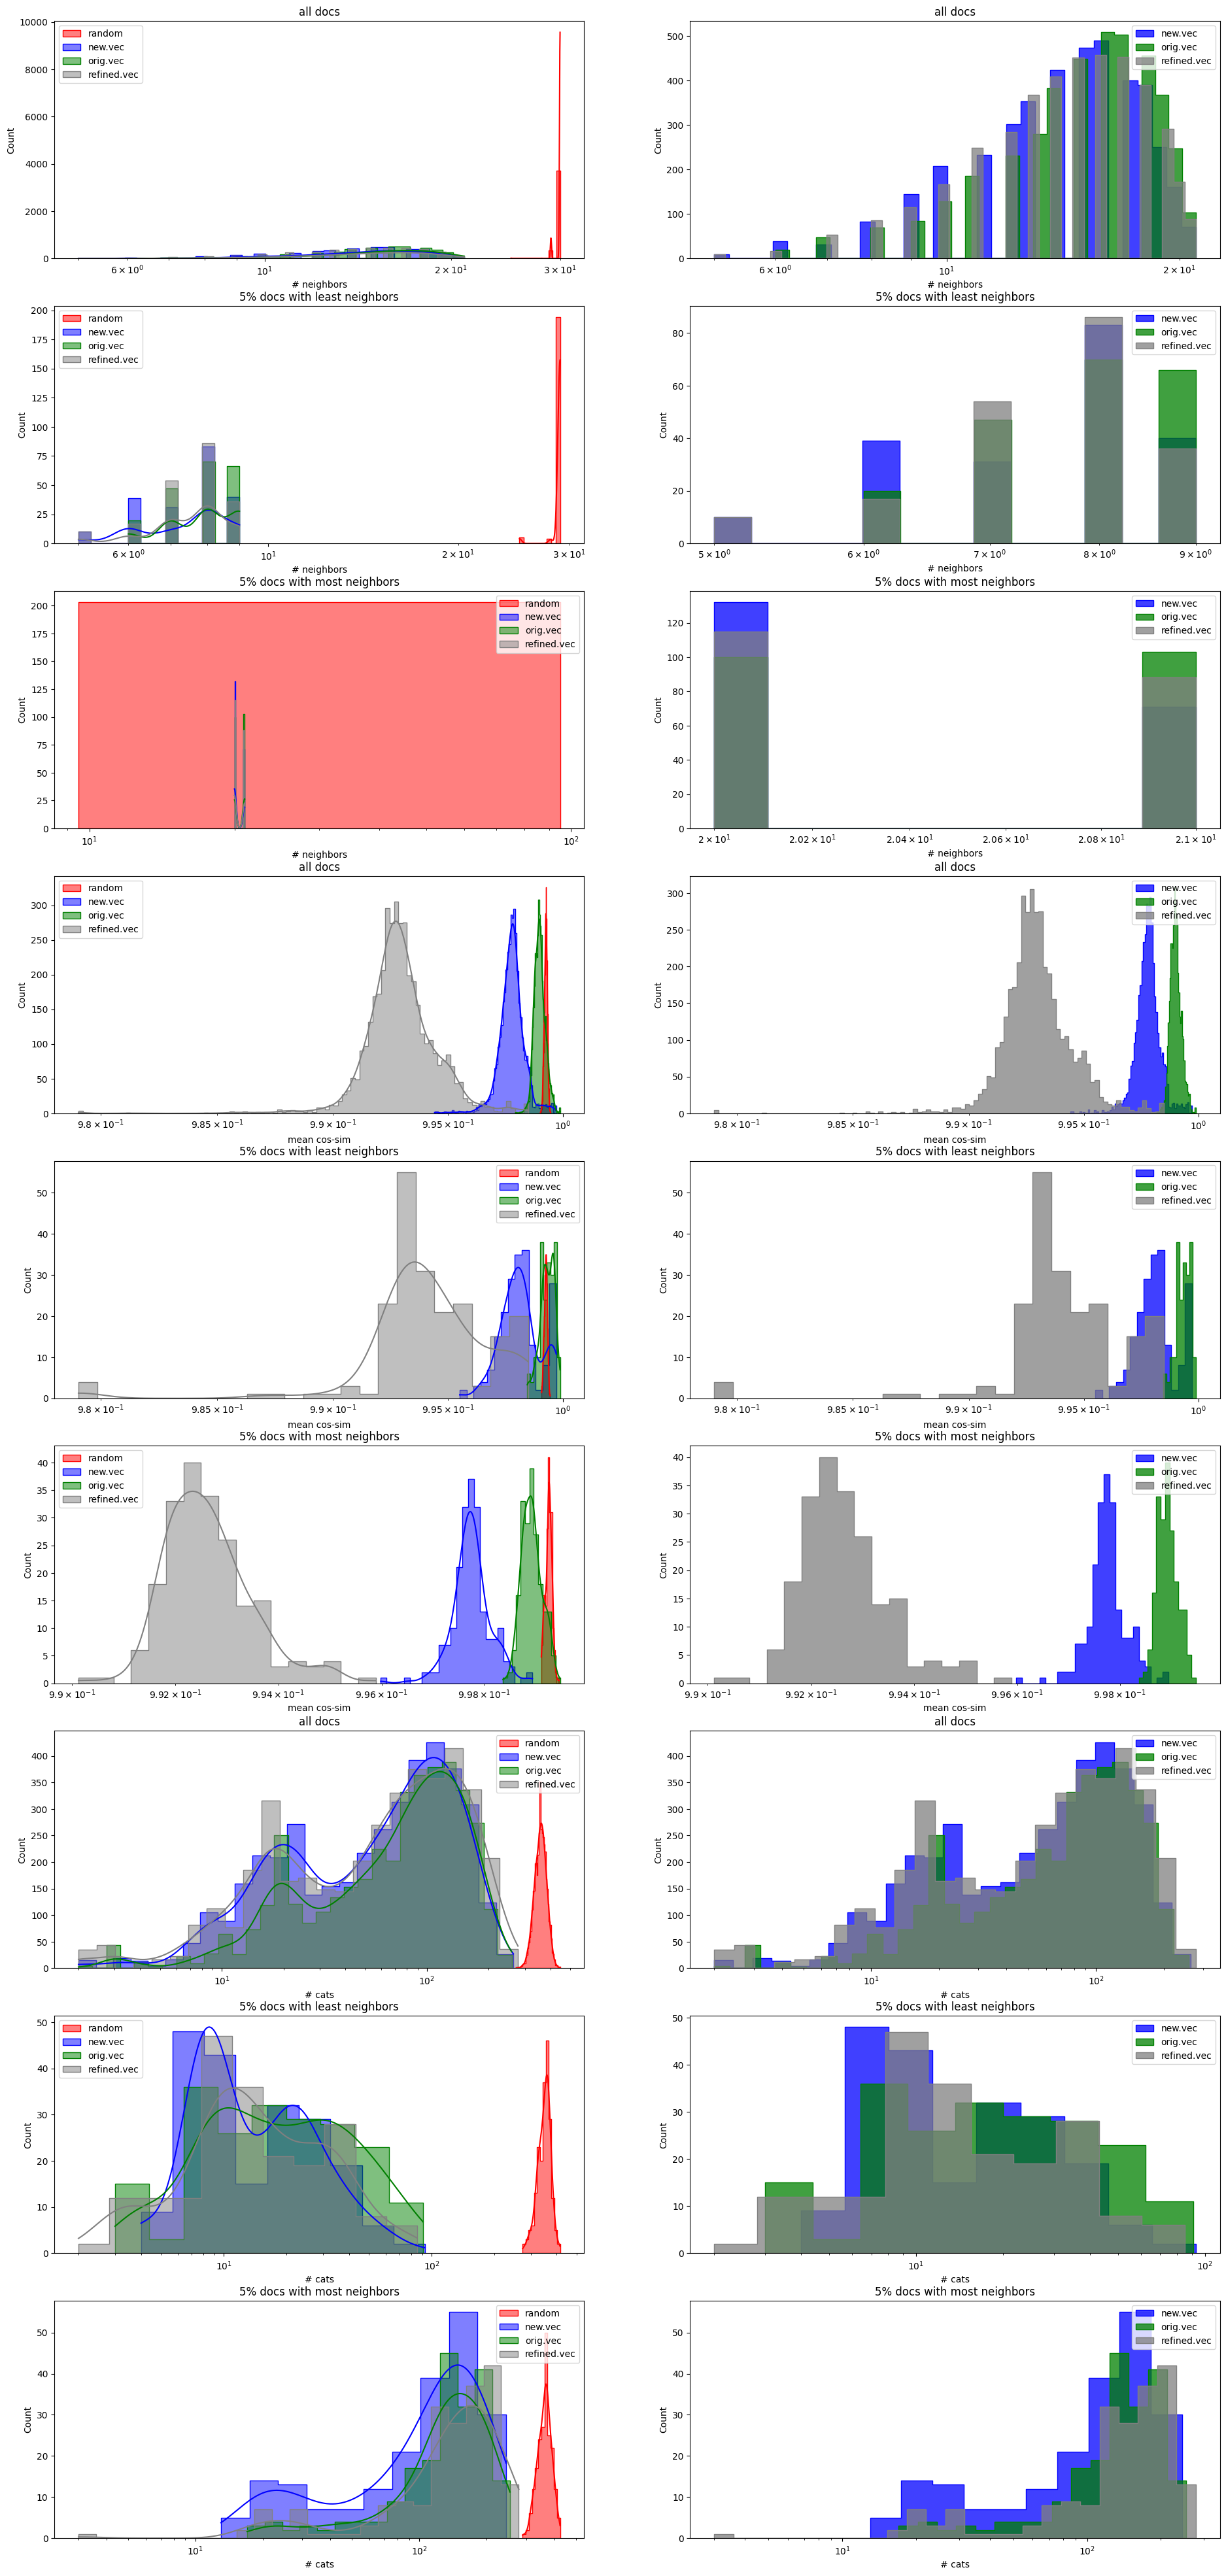

In [25]:
#@title Fearues
Object = KNN()
Object.Plot_Features()

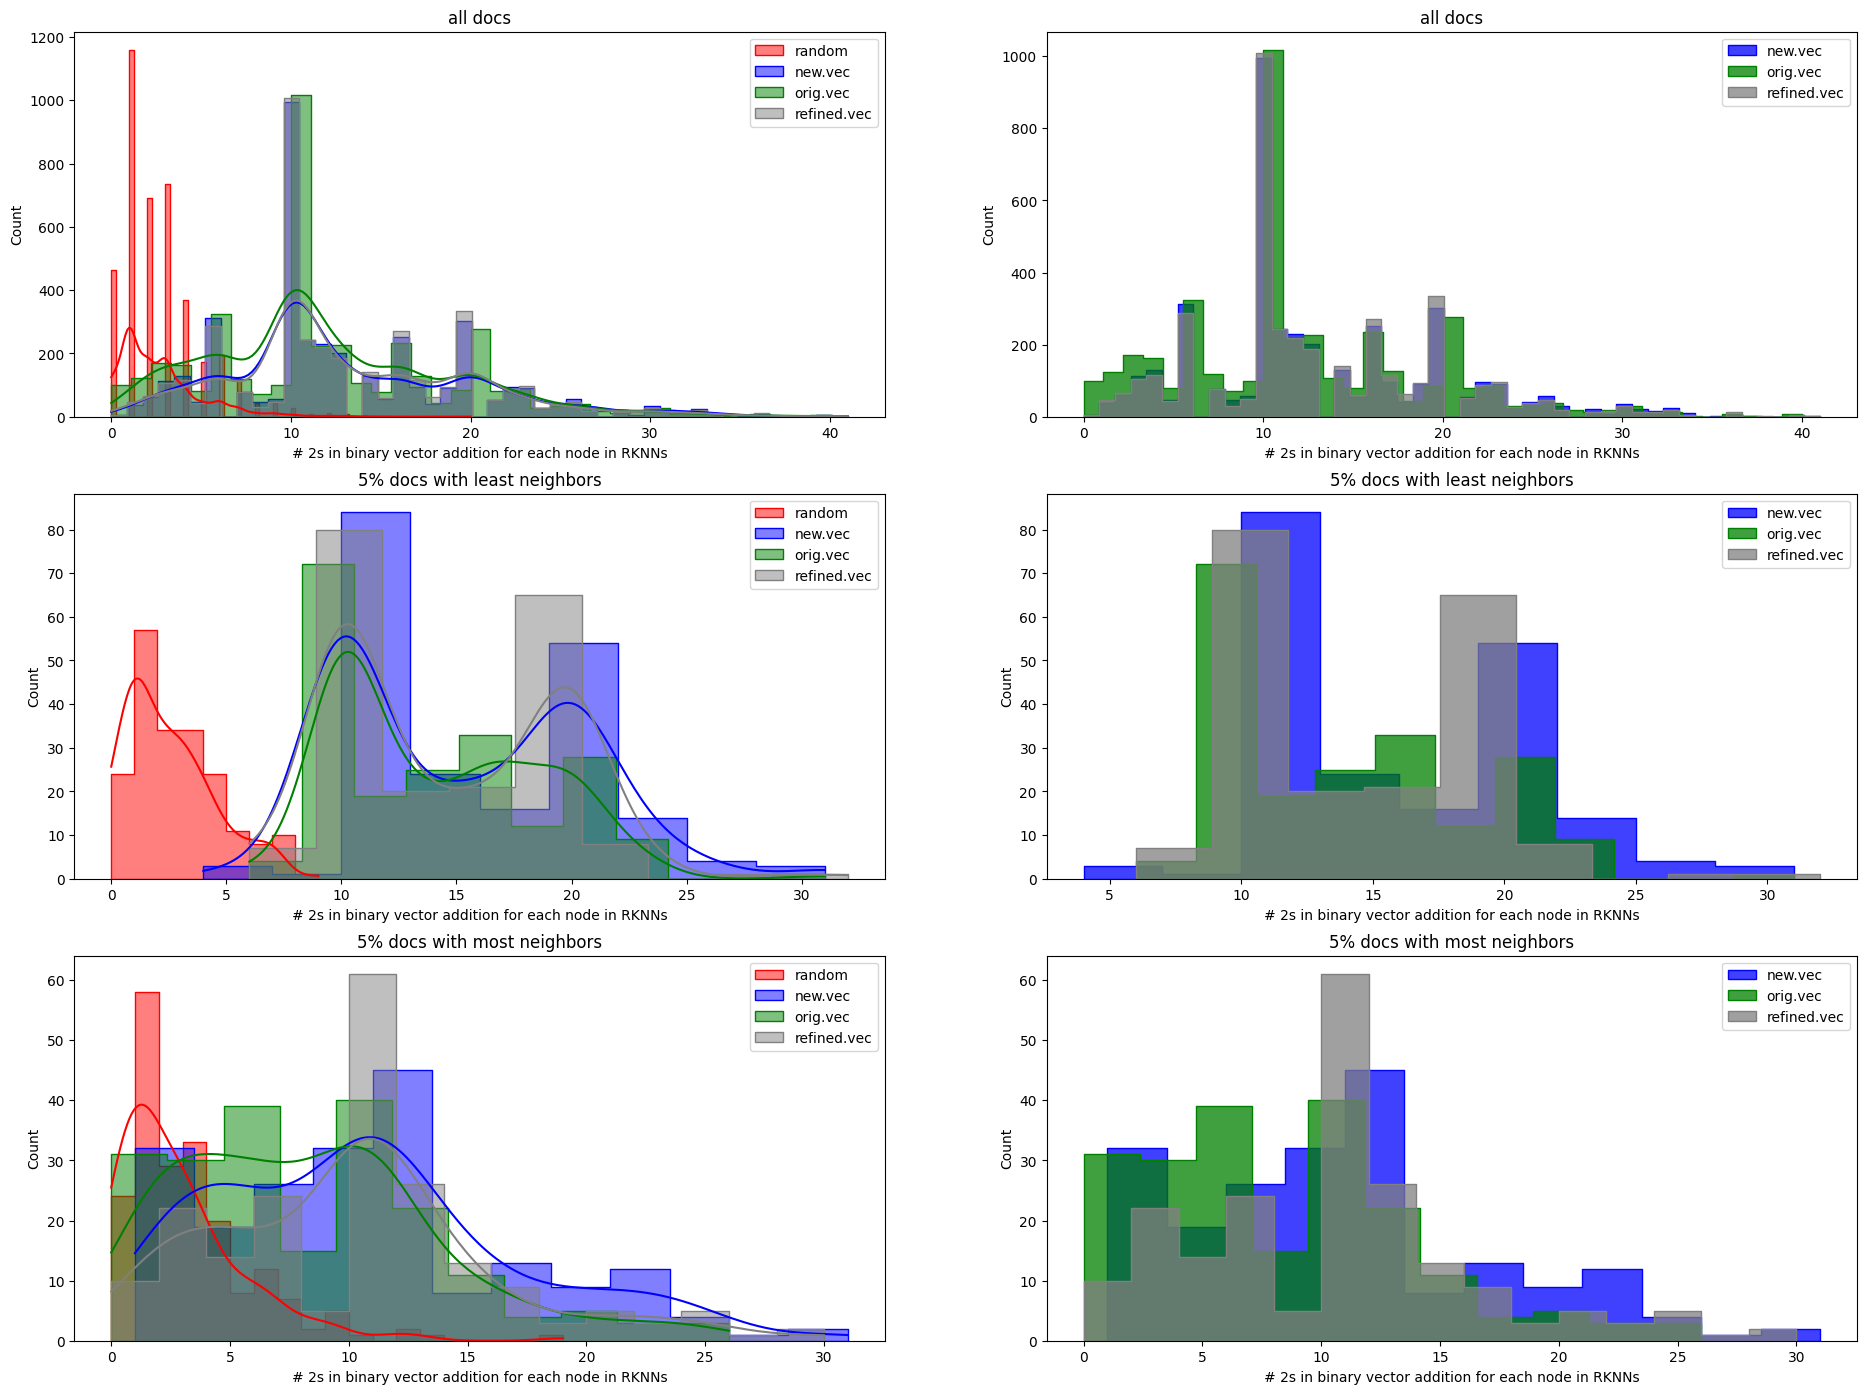

In [26]:
#@title Scores if Use_Cats = True
Object = KNN()
if Use_Cats:
  Object.Plot_Scores(keys, KNN_scores)

random
The KNN graph has 13 communities.


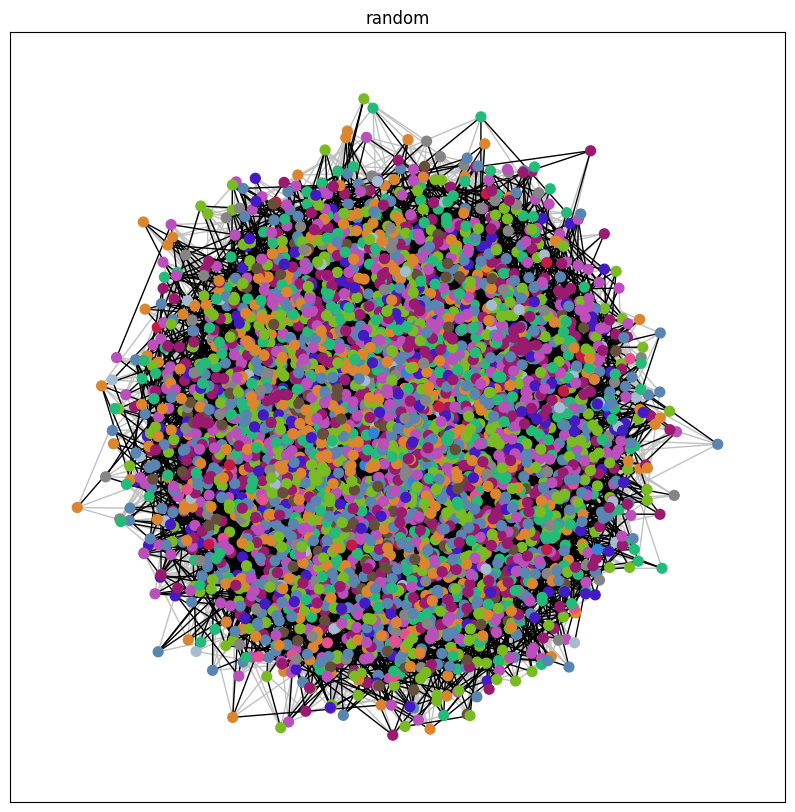


new.vec
The KNN graph has 21 communities.


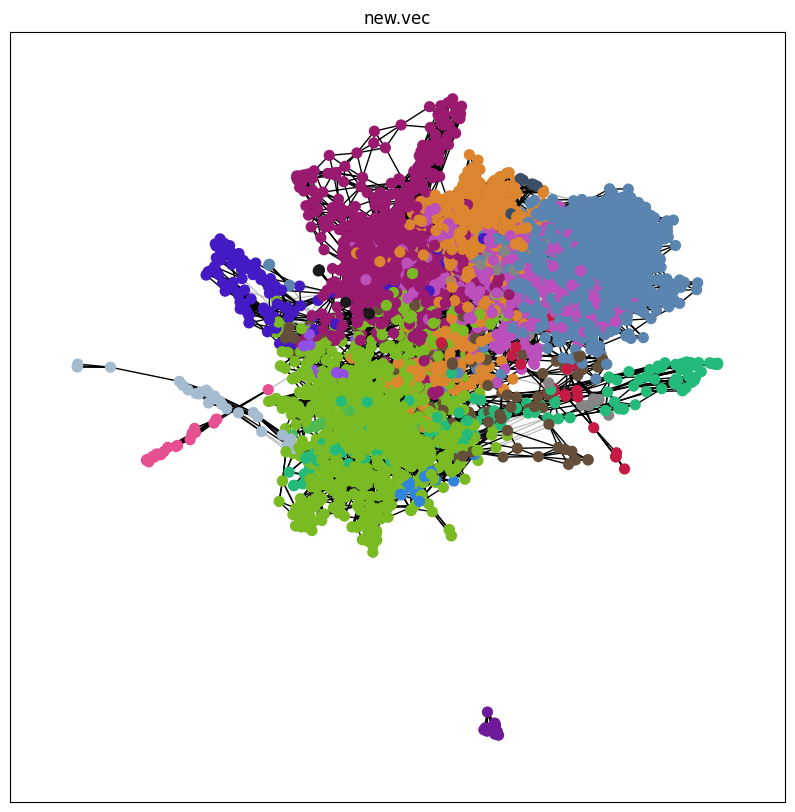


orig.vec
The KNN graph has 17 communities.


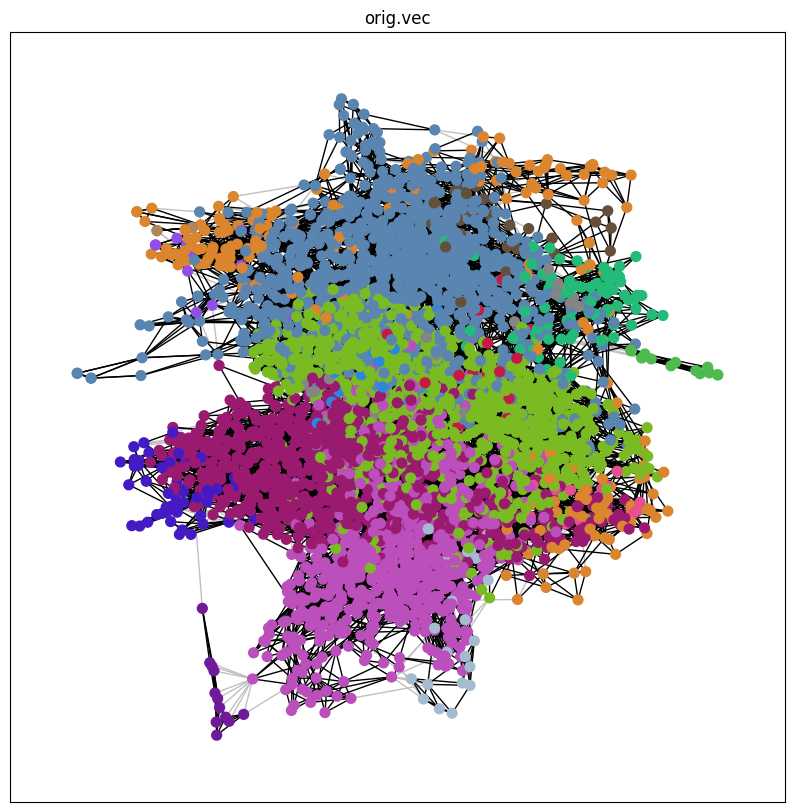


refined.vec
The KNN graph has 20 communities.


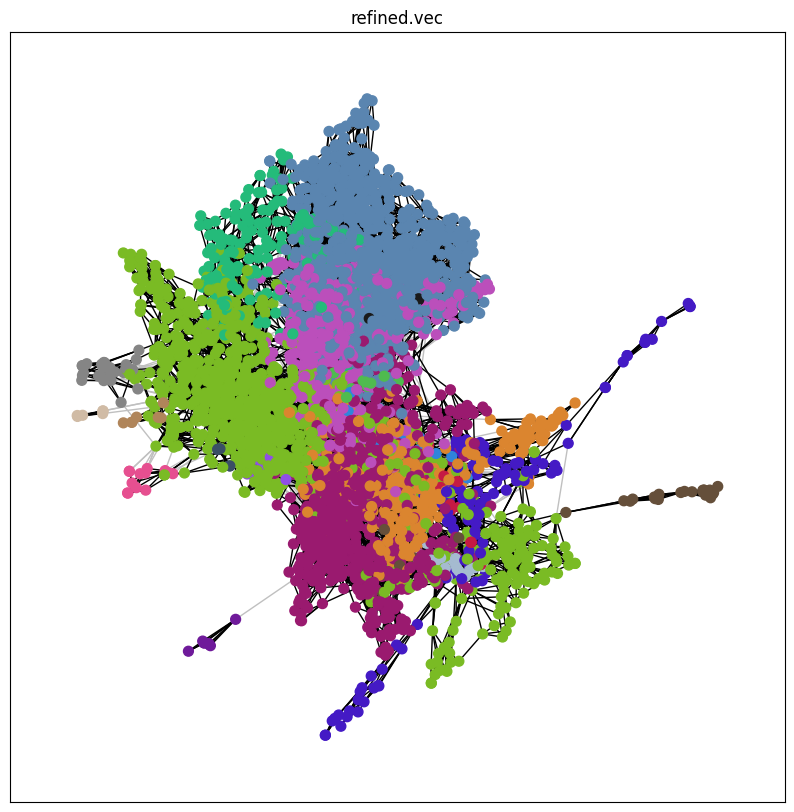

In [27]:
#@title Community
C = Community()
for i in all_graphs.keys():
  print('\x1b[1;30m'+i+'\x1b[0;30m')
  all_graphs[i]['Graph'], all_graphs[i]['Communities'] = C.Community_Detection(all_graphs[i]['df_graph'], all_graphs[i]['df_similarty'], i, Resolution=1)
  print()

In [28]:
df_community = pd.DataFrame(columns=['community', 'Number of docs', f'Mean of {cos_or_L2}', 'Number of unique cats', 'intersection'])
#@title Communities' properties
for i in all_graphs.keys():
  all_graphs[i]['number_docs'], all_graphs[i]['mean_'+cos_or_L2] , all_graphs[i]['number_cats'] = [], [], []
  # Derive the number of docs, number of cats, mean of similarity for each community
  for k, j in enumerate(all_graphs[i]['Communities']):
    temp, sum_sim, count = [], 0, 0
    for doc in range(len(j)):
      temp = temp + Docs_Cats[doc]
      for doc2 in range(doc+1, len(j), 1):
        sum_sim += all_graphs[i]['df_similarty'].loc[list(j)[doc]][list(j)[doc2]]
        count += 1
    temp = list(dict.fromkeys(temp))
    all_graphs[i]['number_docs'].append(len(j))
    all_graphs[i]['mean_'+cos_or_L2].append(sum_sim/count)
    all_graphs[i]['number_cats'].append(len(temp))
    # Find communities in other models with most number of intersection
    li = []
    for ii in all_graphs.keys():
      if i != ii and ii!='random' and i!='random':
        max, max_ind = 0, 0
        for kk, jj in enumerate(all_graphs[ii]['Communities']):
          intersection = np.intersect1d(np.array(list(jj)), np.array(list(j)))
          if len(intersection) > max:
            max = len(intersection)
            max_ind = kk
        li.append([ii, max_ind+1, max])
    row = {'community': f'{i} {k+1}', 'Number of docs': len(j), f'Mean of {cos_or_L2}': sum_sim/count, 'Number of unique cats': len(temp), 'intersection': li}
    df_community = df_community.append(row, ignore_index=True)

display(df_community)

,community,Number of docs,Mean of cos,Number of unique cats,intersection
0,random 1,659,0.500659,1148,[]
1,random 2,657,0.501645,1142,[]
2,random 3,587,0.501948,1051,[]
3,random 4,581,0.501554,1045,[]
4,random 5,479,0.502938,922,[]
...,...,...,...,...,...
66,refined.vec 16,7,0.987033,37,"[[new.vec, 5, 6], [orig.vec, 1, 7]]"
67,refined.vec 17,7,0.988306,37,"[[new.vec, 16, 7], [orig.vec, 9, 7]]"
68,refined.vec 18,6,0.992064,31,"[[new.vec, 7, 6], [orig.vec, 5, 5]]"
69,refined.vec 19,5,0.973106,31,"[[new.vec, 2, 5], [orig.vec, 1, 5]]"


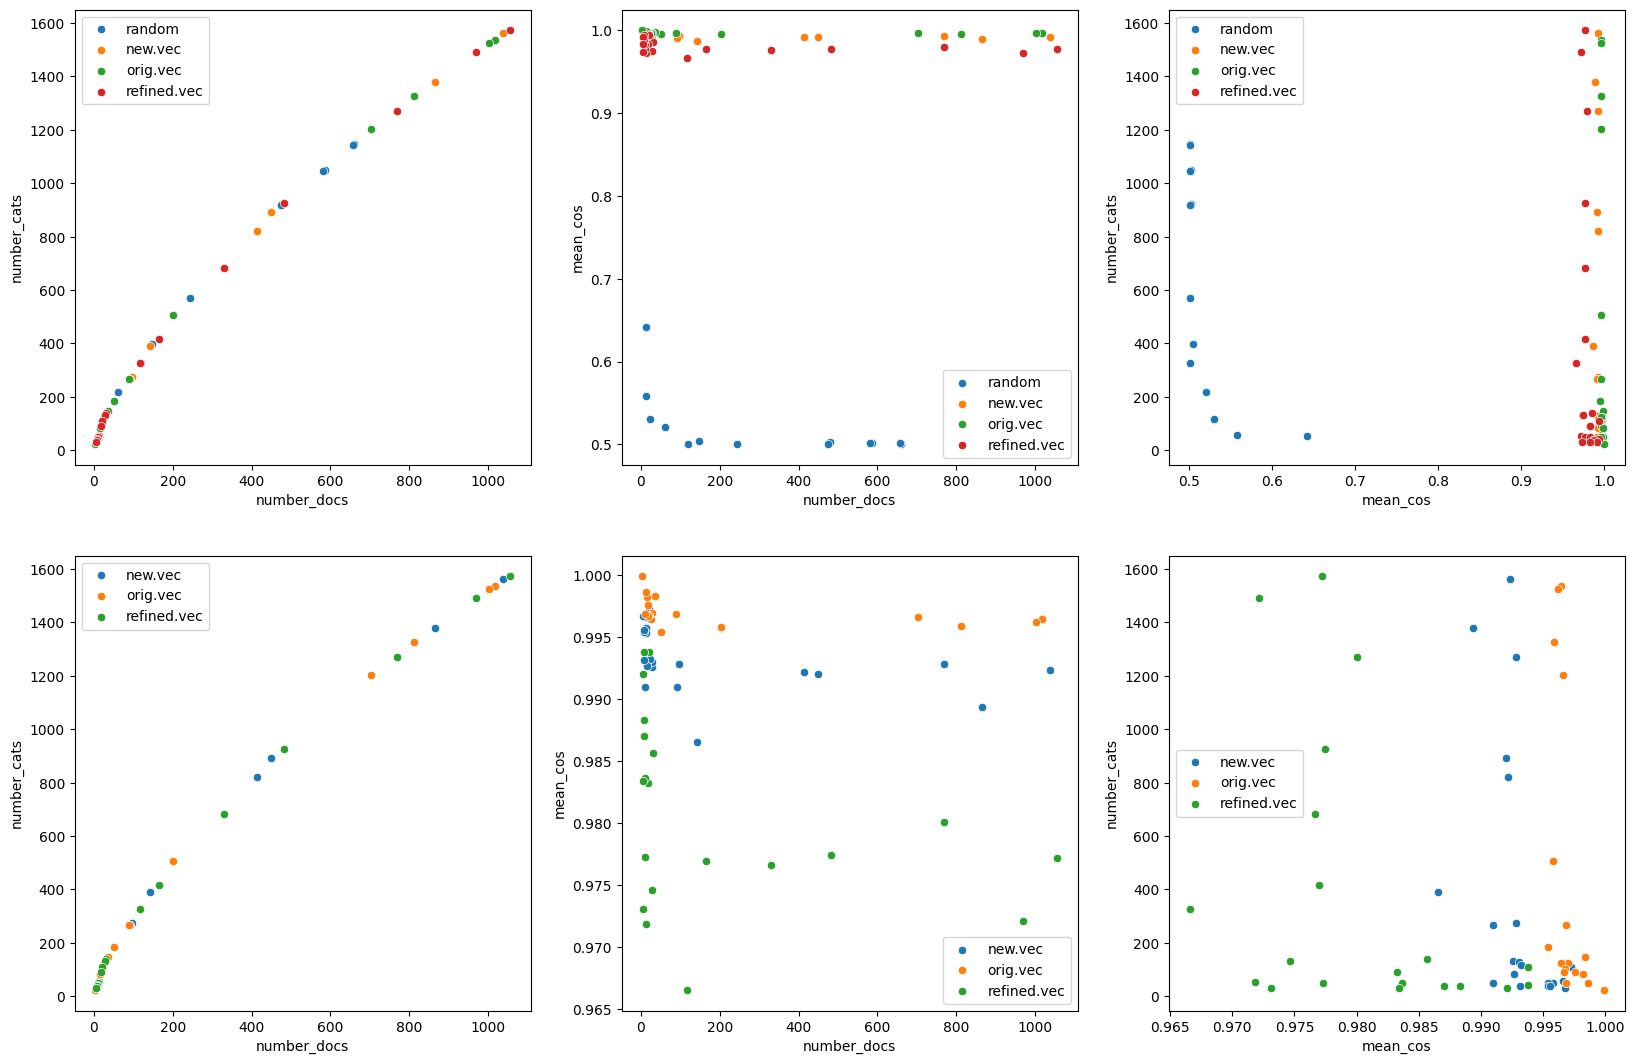

In [29]:
f, axes= plt.subplots(2, 3, figsize=(20, 13))
for i in all_graphs.keys():
  df_temp = pd.DataFrame({'number_docs': all_graphs[i]['number_docs'], 'mean_'+cos_or_L2: all_graphs[i]['mean_'+cos_or_L2], 'number_cats': all_graphs[i]['number_cats']})
  sns.scatterplot(data=df_temp, x='number_docs', y='number_cats', ax=axes[0][0], label=i)
  sns.scatterplot(data=df_temp, x='number_docs', y='mean_'+cos_or_L2, ax=axes[0][1], label=i)
  sns.scatterplot(data=df_temp, x='mean_'+cos_or_L2, y='number_cats', ax=axes[0][2], label=i)
  if i != 'random':
    df_temp = pd.DataFrame({'number_docs': all_graphs[i]['number_docs'], 'mean_'+cos_or_L2: all_graphs[i]['mean_'+cos_or_L2], 'number_cats': all_graphs[i]['number_cats']})
    sns.scatterplot(data=df_temp, x='number_docs', y='number_cats', ax=axes[1][0], label=i)
    sns.scatterplot(data=df_temp, x='number_docs', y='mean_'+cos_or_L2, ax=axes[1][1], label=i)
    sns.scatterplot(data=df_temp, x='mean_'+cos_or_L2, y='number_cats', ax=axes[1][2], label=i)
plt.show()

In [30]:
#@title Communities' Features
df_community_mean = pd.DataFrame(columns=['community', '# neighbors', 'mean cos-sim', '# cats'])
Community_Scores = {}

for k, name in enumerate(all_graphs.keys()):
  Community_Scores[name] = {}
  # f, axes= plt.subplots(9, 2, figsize=(23, 50))
  colors = ['red', 'blue', 'green', 'grey']
  sim = 'mean L2-norm'
  if 'cos' in cos_or_L2:
    sim = 'mean cos-sim'
  counter = 0
  for comm_indx in [2, 3, 4, 5, 6, 7, 8]:
    comm_docs = list(all_graphs[name]['Communities'][comm_indx])
    similarity = all_graphs[name]['df_similarty'].loc[comm_docs][comm_docs].values
    Dict_top_k, R_KNN_Properties, KNN_scores, df_graph = Object.knn(similarity, Docs_Cats, df_labels[used_cats], comm_docs, int(K), int(nHops))
    # Extract features
    Extracted_Properties, keys = Object.Extract_Features(R_KNN_Properties, cos_or_L2, name, community_level=True)
    least_neighbors = keys[:(len(keys)*5//100)]
    most_neighbors = keys[-(len(keys)*5//100):]
    # Save Scores
    Community_Scores[name][comm_indx+1] = []
    for i in keys:
      Community_Scores[name][comm_indx+1].append(KNN_scores[i])
    arr = Extracted_Properties
    row = {'community': f'{name} {comm_indx+1}'}
    for count,i in enumerate(['# neighbors', sim, '# cats']):
      row[i] = np.mean(Extracted_Properties[:, count])
      # axes = Object.Plot(axes, i, k, arr[:, count], counter, colors, name, Log_scale=[True, False])
      counter += 3
    counter = 0
    df_community_mean = df_community_mean.append(row, ignore_index=True)
  # plt.show()
display(df_community_mean)

,community,# neighbors,mean cos-sim,# cats
0,random 3,29.349233,0.996595,342.441227
1,random 4,29.407917,0.996762,337.788296
2,random 5,29.156576,0.995761,310.686848
3,random 6,29.128421,0.995752,303.324211
4,random 7,28.559184,0.991561,295.330612
5,random 8,27.510204,0.986417,256.795918
6,random 9,26.529412,0.980985,238.117647
7,new.vec 3,14.274382,0.998301,18.321196
8,new.vec 4,14.264444,0.997680,111.953333
9,new.vec 5,14.629540,0.997665,21.782082


[5 2 6]


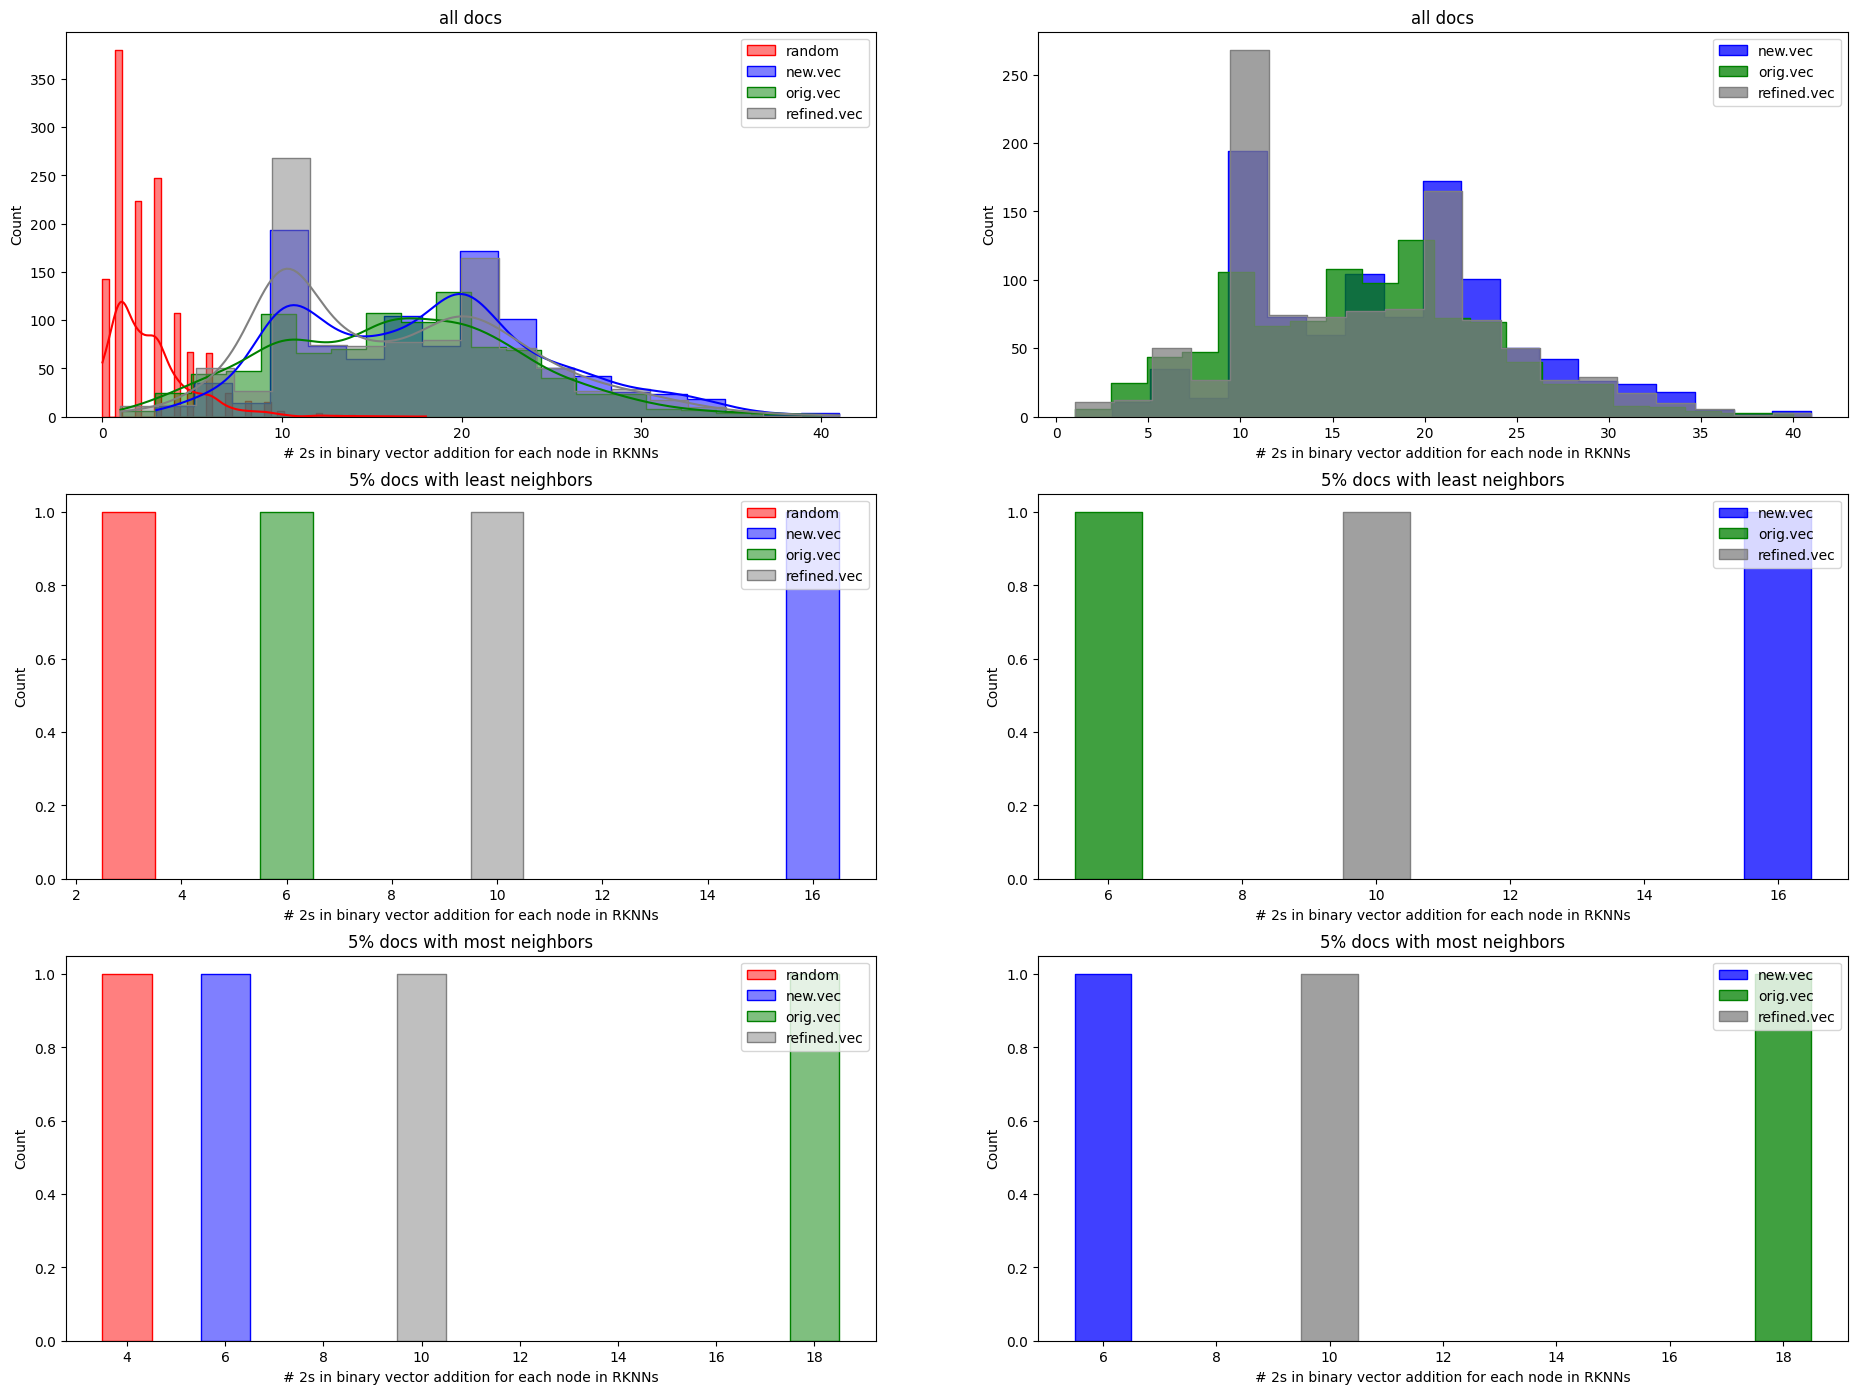

In [31]:
#@title Choose randomly from the communities and plot Scores
f, axes= plt.subplots(3, 2, figsize=(23, 17))
counter = 0
cl = '# 2s in binary vector addition for each node in RKNNs'
colors = ['red', 'blue', 'green', 'grey']
rand = np.random.choice([2, 3, 4, 5, 6, 7, 8], 3, replace=False)
print(rand)
for k, i in enumerate(Community_Scores.keys()):
  li = []
  df_temp = pd.DataFrame()
  for j in rand:
    li += Community_Scores[i][j+1]
  axes = Object.Plot(axes, cl, k, arr=li, counter=0, colors=colors, label=i, Log_scale=[False, False])